Set up

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
FILE = "bills_copy.csv"
VENUE = "venues_copy.csv"
HOLIDAY = "holiday.csv"
pd.set_option("display.max_columns", None)

Data Cleaning

In [2]:
df_bills = pd.read_csv(FILE)
df_venues = pd.read_csv(VENUE)
df_holiday = pd.read_csv(HOLIDAY)
merged_df = pd.merge(df_bills, df_venues, on='venue_xref_id', how='left')

# bills columns format conversion
merged_df['business_date'] = pd.to_datetime(merged_df['business_date'])
merged_df['bill_paid_at_local'] = pd.to_datetime(merged_df['bill_paid_at_local'], errors='coerce')
merged_df['order_seated_at_local'] = pd.to_datetime(merged_df['order_seated_at_local'], errors='coerce')
merged_df['order_closed_at_local'] = pd.to_datetime(merged_df['order_closed_at_local'], errors='coerce')
merged_df['bill_total_billed'] = pd.to_numeric(merged_df['sales_revenue_with_tax'], errors='coerce')

# venues columns format conversion
merged_df['concept'] = merged_df['concept'].astype(str)
merged_df['start_of_day_offset'] = pd.to_datetime(merged_df['start_of_day_offset'], format="%H:%M:%S").dt.time
merged_df['sales_revenue_with_tax'] = pd.to_numeric(merged_df['sales_revenue_with_tax'], errors='coerce')

# holiday columns format conversion
df_holiday['Date'] = pd.to_datetime(df_holiday['Date'])
df_holiday['Country'].replace({'Canada': 'CA', 'USA': 'US'})

# merge 3 dataframes together
df = pd.merge(merged_df, df_holiday, how="left",
                     left_on=["business_date"],
                     right_on=["Date"])

# drop all columns from holiday.csv and add 'is_holiday' column
# in 'is_holiday' query 1 if holiday and 0 otherwise
df['is_holiday'] = df['business_date'].isin(df_holiday['Date']).astype(int)
df.drop(columns=["Date", "Holiday", "Day", "Country"], inplace=True)

In [3]:
# merge 3 dataframes together
df = pd.merge(merged_df, df_holiday, how="left",
                     left_on=["business_date"],
                     right_on=["Date"])

# drop all columns from holiday.csv and add 'is_holiday' column
# in 'is_holiday' query 1 if holiday and 0 otherwise
df['is_holiday'] = df['business_date'].isin(df_holiday['Date']).astype(int)

Bar chart (holiday vs non-holiday)

C:\Users\soojs\AppData\Local\Temp\ipykernel_32084\2445474919.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='is_holiday', y='bill_total_billed', data=mean_bills, palette='coolwarm')


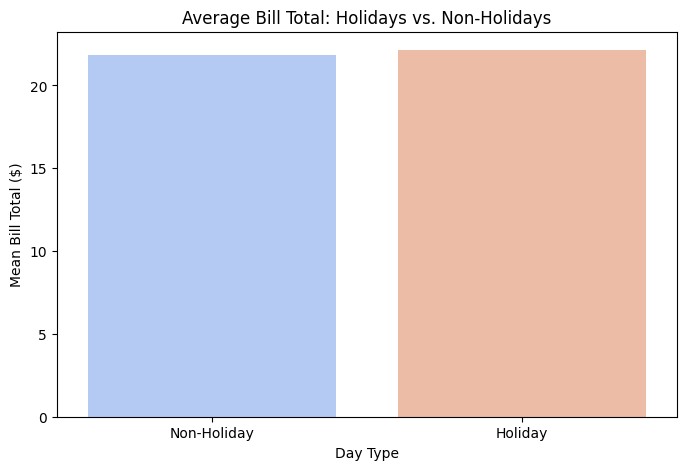

In [4]:
mean_bills = df.groupby('is_holiday')['bill_total_billed'].median().reset_index()

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x='is_holiday', y='bill_total_billed', data=mean_bills, palette='coolwarm')

# Add labels and title
plt.xticks([0, 1], ['Non-Holiday', 'Holiday'])
plt.title('Average Bill Total: Holidays vs. Non-Holidays')
plt.xlabel('Day Type')
plt.ylabel('Mean Bill Total ($)')

plt.show()

Bar chart (holiday vs non-holiday for each venue)

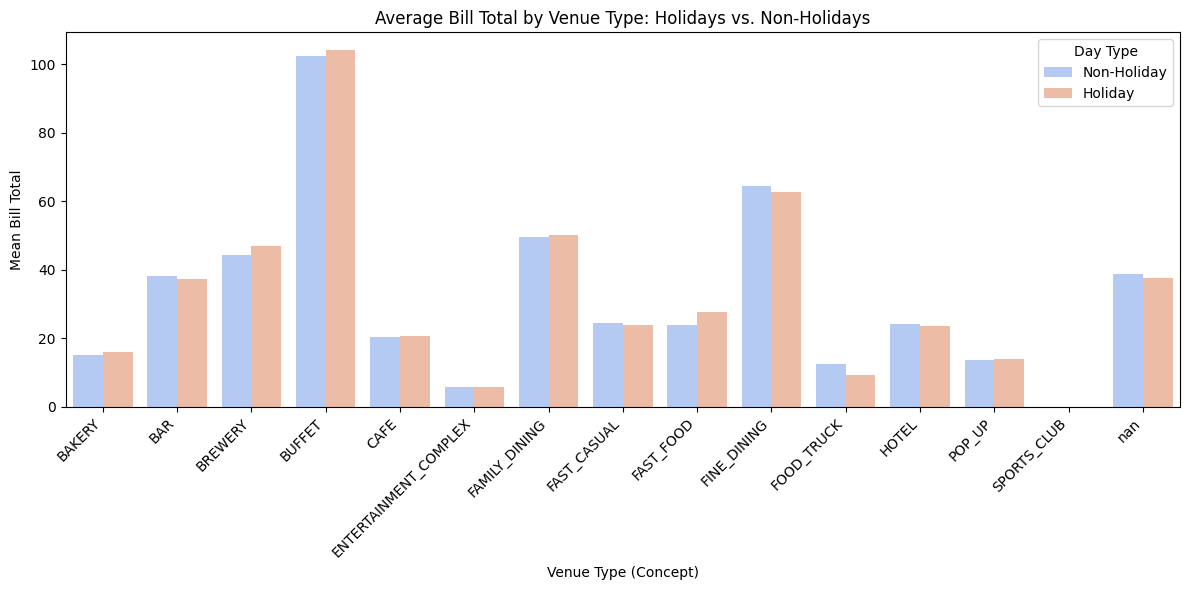

In [5]:
grouped_data = df.groupby(['concept', 'is_holiday'])['bill_total_billed'].mean().reset_index()

# Plot grouped bar chart
plt.figure(figsize=(12, 6))
sns.barplot(x='concept', y='bill_total_billed', hue='is_holiday', data=grouped_data, palette='coolwarm')

# Add labels and title
plt.title('Average Bill Total by Venue Type: Holidays vs. Non-Holidays')
plt.xlabel('Venue Type (Concept)')
plt.ylabel('Mean Bill Total')
plt.xticks(rotation=45, ha='right')

# Create a dictionary mapping values to custom labels
label_map = {0: 'Non-Holiday', 1: 'Holiday'}

# Update the legend labels dynamically
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles, [label_map[int(label)] for label in labels], title='Day Type')

plt.tight_layout()
plt.show()

T-Test (for all venues)

In [7]:
from scipy import stats

# Separate holiday and non-holiday sales
holiday_sales = df[df['is_holiday'] == 1]['bill_total_billed']
non_holiday_sales = df[df['is_holiday'] == 0]['bill_total_billed']

# Perform t-test
t_stat, p_value = stats.ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

if p_value < 0.05:
    print("There is a statistically significant difference in sales between holidays and non-holidays.")
else:
    print("No statistical significant difference in sales between holidays and non-holidays.")

T-statistic: 1.51
P-value: 0.1315
No statistical significant difference in sales between holidays and non-holidays.


T-Test (for each venue)

In [ ]:
# t-testing set up

from scipy import stats

venues = df['concept'].unique()

results = []

# Iterate through each unique venue type
for venue in df['concept'].unique():
    # Filter sales data for this venue type
    holiday_sales = df[(df['is_holiday'] == 1) & (df['concept'] == venue)]['bill_total_billed']
    non_holiday_sales = df[(df['is_holiday'] == 0) & (df['concept'] == venue)]['bill_total_billed']
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(holiday_sales, non_holiday_sales, equal_var=False)
    
    # Check for significance
    significant = 'Yes' if p_value < 0.05 else 'No'
    
    # Append results
    results.append({
        'Venue Type': venue,
        'T-stat': t_stat,
        'P-value': p_value,
        'Significant Difference?': significant
    })

    # Convert the results into a DataFrame
    results_df = pd.DataFrame(results)

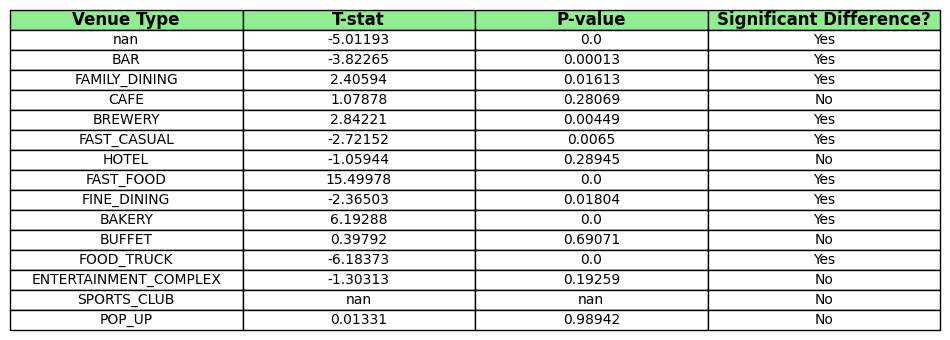

In [ ]:
# t-testing result visualization

# Round the T-stat and P-value columns to 5 decimal places
results_df['T-stat'] = results_df['T-stat'].round(5)
results_df['P-value'] = results_df['P-value'].round(5)

# Plot using matplotlib
fig, ax = plt.subplots(figsize=(10, 4))  # Adjust the figure size as needed
ax.axis('off')  # Turn off the axis to focus on the table

# Create the table
table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center', cellLoc='center', colColours=["#4CAF50"] * len(results_df.columns))

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)  # Increase size for readability

# Alternate row colors for better readability
for i, key in enumerate(table.get_celld().keys()):
    cell = table.get_celld()[key]
    if key[0] == 0:
        cell.set_fontsize(12)
        cell.set_text_props(weight='bold')  # Make the header bold
        cell.set_facecolor('#90EE90')  # Header background color
    
    # Highlight the 'Significant Difference?' column where value is 'Yes'
    if key[1] == 'Significant Difference?' and cell.get_text().get_text() == 'Yes':
        cell.set_facecolor('red')  # Highlight in red

# Show the plot
plt.show()